In [81]:
!pip install geemap
!pip install leafmap
!pip install rasterio
!pip install geopandas
!pip install torch
!pip install torchvision
!pip install torchmetrics
!pip install matplotlib
!pip install seaborn

In [82]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Q2: Label Construction & Dataset Prep
1. Load Sentinel-2 tiles
2. Get coordinates from filenames  
3. Extract 128x128 patches
4. Assign labels using ESA WorldCover classes  
5. Handle no-data or mixed areas  
6. Map ESA codes to readable labels  
7. Split data train/test
8. Plot class distribution  


In [117]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [118]:
ESA_to_label = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare",
    70: "Snow/Ice",
    80: "Water",
    90: "Wetland",
    95: "Mangrove",
    100: "Moss/Lichen"
}

In [119]:
label_to_idx = {label: idx for idx, label in enumerate(ESA_to_label.values())}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
print(f"ESA WorldCover mapping loaded: {len(ESA_to_label)} classes")

ESA WorldCover mapping loaded: 11 classes


In [120]:
import glob
import os
sentinel_tiles_dir1 = '/content/drive/MyDrive/IITG_assignments/Selection_Task/EarthEngine_Delhi_Export/'
sentinel_tiles_dir2 = '/content/drive/MyDrive/selection_task/EarthEngine_Delhi_Export/'
tile_paths = []
for sentinel_tiles_dir in [sentinel_tiles_dir1, sentinel_tiles_dir2]:
    for ext in ['*.tif', '*.tiff', '*.TIF', '*.TIFF']:
        tile_paths.extend(glob.glob(os.path.join(sentinel_tiles_dir, ext)))
print(f"Found {len(tile_paths)} Sentinel-2 tiles")
if len(tile_paths) > 0:
    print("\nSample tile paths:")
    for path in tile_paths[:3]:
        print(f"  - {os.path.basename(path)}")
else:
    print("No tiles found!")

Found 49 Sentinel-2 tiles

Sample tile paths:
  - delhi_tile_0_0.tif
  - delhi_tile_0_1.tif
  - delhi_tile_0_2.tif


In [121]:
import os
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
possible_base_dirs = [
    '/content/drive/MyDrive/IITG_assignments/Selection_Task',
    '/content/drive/MyDrive/selection_task',
    '/content/drive/MyDrive/IITG_assignments/selection_task',
    '/content/drive/MyDrive',
]

In [122]:
delhi_airshed = None
delhi_airshed_path = None

for base_dir in possible_base_dirs:
    test_path = os.path.join(base_dir, 'delhi_airshed.shp')
    if os.path.exists(test_path):
        delhi_airshed_path = test_path
        print(f"Found delhi_airshed.shp at: {delhi_airshed_path}")
        break

if delhi_airshed_path is None:
    print("File not found in expected locations. Searching recursively...")
    for base_dir in possible_base_dirs:
        if os.path.exists(base_dir):
            for root, dirs, files in os.walk(base_dir):
                if 'delhi_airshed.shp' in files:
                    delhi_airshed_path = os.path.join(root, 'delhi_airshed.shp')
                    print(f"Found delhi_airshed.shp at: {delhi_airshed_path}")
                    break
            if delhi_airshed_path:
                break

Found delhi_airshed.shp at: /content/drive/MyDrive/IITG_assignments/Selection_Task/delhi_airshed.shp


Delhi Airshed shapefile loaded successfully
Number of features: 1
CRS: EPSG:4326


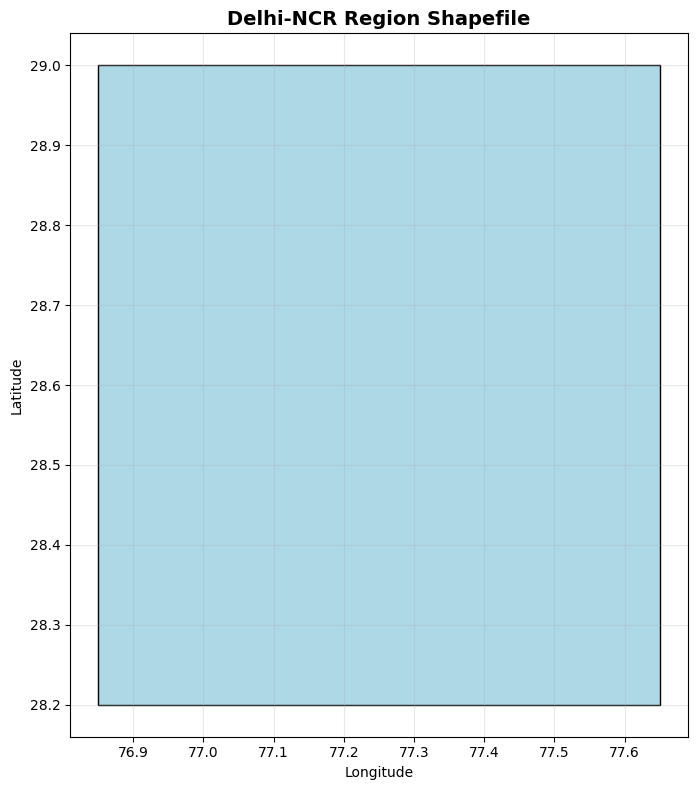

In [123]:
if delhi_airshed_path and os.path.exists(delhi_airshed_path):
    try:
        delhi_airshed = gpd.read_file(delhi_airshed_path)
        print(f"Delhi Airshed shapefile loaded successfully")
        print(f"Number of features: {len(delhi_airshed)}")
        print(f"CRS: {delhi_airshed.crs}")
        plt.figure(figsize=(10, 8))
        delhi_airshed.plot(ax=plt.gca(), facecolor='lightblue', edgecolor='black', linewidth=1)
        plt.title('Delhi-NCR Region Shapefile', fontsize=14, fontweight='bold')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"\n Error loading shapefile: {e}")
        delhi_airshed = None
else:
    print("ERROR: delhi_airshed.shp NOT FOUND")
    print("\nPlease ensure the shapefile is in one of these locations:")
    for path in possible_base_dirs:
        print(f"  - {path}/delhi_airshed.shp")
    print("\nSearched directories:")
    for base_dir in possible_base_dirs:
        if os.path.exists(base_dir):
            print(f"  {base_dir} (exists)")
            # List files in the directory
            try:
                files = os.listdir(base_dir)
                shp_files = [f for f in files if f.endswith('.shp')]
                if shp_files:
                    print(f"    Found .shp files: {shp_files}")
                else:
                    print(f"    No .shp files found")
            except:
                pass
        else:
            print(f" {base_dir} (does not exist)")
    delhi_airshed = None

In [124]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import json
from shapely.geometry import mapping

In [125]:
try:
    ee.Authenticate()
    ee.Initialize(project='original-gasket-476222-d1')
    print("Earth Engine initialized successfully")
except Exception as e:
    print(f"Earth Engine initialization error: {e}")

Earth Engine initialized successfully


In [126]:
possible_paths = [
    '/content/drive/MyDrive/IITG_assignments/Selection_Task/delhi_airshed.shp',
    '/content/drive/MyDrive/selection_task/delhi_airshed.shp',
    '/content/drive/MyDrive/IITG_assignments/selection_task/delhi_airshed.shp',
]

In [127]:
delhi_airshed_path = None
for path in possible_paths:
    if os.path.exists(path):
        delhi_airshed_path = path
        break

if delhi_airshed_path is None:
    print("Delhi airshed shapefile not found. Using fallback coordinates.")
    delhi_geom = ee.Geometry.Rectangle([76.8, 28.4, 77.6, 29.0])
    center_lat, center_lon = 28.7, 77.2
else:
    delhi_airshed = gpd.read_file(delhi_airshed_path)
    print(f"Delhi Airshed shapefile loaded: {len(delhi_airshed)} features")
    print(f"Delhi Airshed CRS: {delhi_airshed.crs}")
    if delhi_airshed.crs != 'EPSG:4326':
        delhi_airshed = delhi_airshed.to_crs('EPSG:4326')
    geojson = json.loads(delhi_airshed.to_json())
    delhi_geom = ee.Geometry(geojson['features'][0]['geometry'])
    print("Successfully converted GeoDataFrame to EE Geometry")
    centroid = delhi_airshed.geometry.centroid.iloc[0]
    center_lat = centroid.y
    center_lon = centroid.x

Delhi Airshed shapefile loaded: 1 features
Delhi Airshed CRS: EPSG:4326
Successfully converted GeoDataFrame to EE Geometry


In [128]:
Map = geemap.Map(center=[center_lat, center_lon], zoom=10)
Map.add_basemap('SATELLITE')
Map.addLayer(delhi_geom, {'color': 'red', 'fillColor': '00000000'}, 'Delhi Airshed Boundary')

print("Delhi Airshed grid overlay added with geemap")
print("Map created with satellite basemap")
Map

Delhi Airshed grid overlay added with geemap
Map created with satellite basemap


Map(center=[28.600000000000065, 77.25000000000027], controls=(WidgetControl(options=['position', 'transparent_…

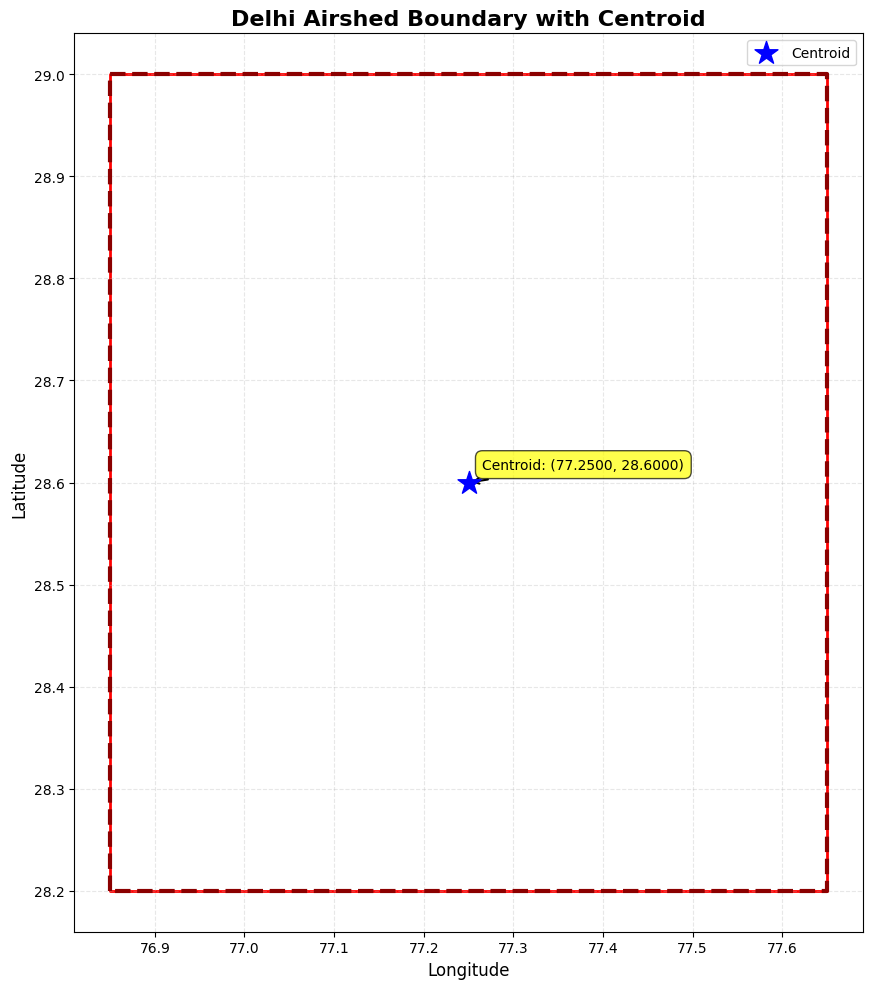

  - Centroid coordinates: (77.2500, 28.6000)


In [129]:
if delhi_airshed_path:
    try:
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        delhi_airshed.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Delhi Airshed')
        delhi_airshed.boundary.plot(ax=ax, edgecolor='darkred', linewidth=3, linestyle='--')
        centroid_gdf = gpd.GeoDataFrame(geometry=[centroid], crs='EPSG:4326')
        centroid_gdf.plot(ax=ax, color='blue', marker='*', markersize=300, label='Centroid', zorder=5)
        ax.set_title('Delhi Airshed Boundary with Centroid', fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.annotate(f'Centroid: ({center_lon:.4f}, {center_lat:.4f})',
                   xy=(center_lon, center_lat),
                   xytext=(10, 10),
                   textcoords='offset points',
                   fontsize=10,
                   bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5))

        plt.tight_layout()
        plt.show()
        print(f"  - Centroid coordinates: ({center_lon:.4f}, {center_lat:.4f})")

    except Exception as e:
        print(f"Error creating matplotlib visualization: {e}")
else:
    print("Skipping matplotlib visualization (shapefile not found)")

In [130]:
base_dirs = [
    '/content/drive/MyDrive/IITG_assignments/Selection_Task',
    '/content/drive/MyDrive/selection_task'
]

dpath = None
for bd in base_dirs:
    tp = os.path.join(bd, 'delhi_airshed.shp')
    if os.path.exists(tp):
        dpath = tp
        break

if not dpath:
    raise FileNotFoundError("delhi_airshed.shp not found!")

dgdf = gpd.read_file(dpath)
print(f"Loaded: {len(dgdf)} feature(s)")
print(f"CRS: {dgdf.crs}")



Loaded: 1 feature(s)
CRS: EPSG:4326


In [131]:
try:
    g = dgdf.geometry.iloc[0]
    if g.geom_type == 'Polygon':
        c = [list(g.exterior.coords)]
        eeg = ee.Geometry.Polygon(c)
    elif g.geom_type == 'MultiPolygon':
        ps = [list(p.exterior.coords) for p in g.geoms]
        eeg = ee.Geometry.MultiPolygon(ps)
    else:
        raise ValueError(f"Unsupported: {g.geom_type}")

    b = dgdf.total_bounds
    print(f"Bounds: [{b[0]:.2f}, {b[1]:.2f}, {b[2]:.2f}, {b[3]:.2f}]")
    print(f"Geometry type: {g.geom_type}")
    print(f"Region used: Delhi Airshed ({b[0]:.2f}°E-{b[2]:.2f}°E, {b[1]:.2f}°N-{b[3]:.2f}°N)")
    geom_ok = True
except Exception as e:
    print(f"Error: {e}")
    print("Expected if EE not authenticated")
    eeg = None
    geom_ok = False


Bounds: [76.85, 28.20, 77.65, 29.00]
Geometry type: Polygon
Region used: Delhi Airshed (76.85°E-77.65°E, 28.20°N-29.00°N)


In [133]:
#Configure Sentinel-2 Parameters
sd = '2025-01-01'
ed = '2025-01-31'
cm = 20


In [134]:
#Query Sentinel-2
if geom_ok:
    try:
        s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(eeg) \
            .filterDate(sd, ed) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cm))

        cnt = s2.size().getInfo()
        print(f"Images found: {cnt}")

        if cnt > 0:
            fi = s2.first().getInfo()
            print(f"Example image: {fi['id']}")
            print("Step 6: Creating Median Composite")
            comp = s2.select(['B4', 'B3', 'B2']).median().clip(eeg)
            print(f"Composite created from {cnt} images")
            print("Bands: B4(Red), B3(Green), B2(Blue)")
            print("Clipped to region")
        else:
            print("No images found")
            cnt = "0"
    except Exception as e:
        print(f"Query error: {str(e)[:50]}")
        cnt = "N/A"
else:
    cnt = "N/A"
print(f" Images found: {cnt}")
print(f" Region: Delhi Airshed")
if geom_ok:
    print(f"Bounds: {b[0]:.2f}°-{b[2]:.2f}°E, {b[1]:.2f}°-{b[3]:.2f}°N")
print(f" Resolution: 10m")
print(f" Date range: {sd} to {ed}")
print(f" Format: GeoTIFF")

Images found: 10
Example image: COPERNICUS/S2_SR_HARMONIZED/20250113T053209_20250113T053803_T43RGM
Step 6: Creating Median Composite
Composite created from 10 images
Bands: B4(Red), B3(Green), B2(Blue)
Clipped to region
 Images found: 10
 Region: Delhi Airshed
Bounds: 76.85°-77.65°E, 28.20°-29.00°N
 Resolution: 10m
 Date range: 2025-01-01 to 2025-01-31
 Format: GeoTIFF


In [135]:
# Q2: Label Construction & Dataset Preparation (10 Marks)
# Q2.1: Extract 128x128 patches from land_cover.tif (2 marks)
def extract_patch_from_landcover(land_cover_path, center_x, center_y, patch_size=128):
    """Extract a patch_size x patch_size patch centered at (center_x, center_y) from land_cover raster"""
    try:
        with rasterio.open(land_cover_path) as src:
            row, col = src.index(center_x, center_y)
            half_size = patch_size // 2
            window = Window(col - half_size, row - half_size, patch_size, patch_size)
            patch = src.read(1, window=window)
            return patch
    except Exception as e:
        print(f"Error extracting patch: {e}")
        return None

def assign_label_to_patch(patch, ESA_to_label):
    valid_pixels = patch[patch > 0].flatten()
    if len(valid_pixels) == 0:
        return "No-data", None
    class_mode = mode(valid_pixels, keepdims=True).mode[0]
    label = ESA_to_label.get(class_mode, "Unknown")
    return label, class_mode

In [136]:
# Q3: Model Training & Supervised Evaluation (10 Marks)
# Q3.1: Train/Test Split (60/40) (1 mark)
from sklearn.model_selection import train_test_split
def visualize_class_distribution(y_train, y_test, ESA_to_label):
    """Visualize class distribution in train and test sets"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    unique, counts = np.unique(y_train, return_counts=True)
    labels = [ESA_to_label.get(c, f"Class {c}") for c in unique]
    ax1.bar(labels, counts, color='skyblue', edgecolor='black')
    ax1.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Land Cover Class')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    unique, counts = np.unique(y_test, return_counts=True)
    labels = [ESA_to_label.get(c, f"Class {c}") for c in unique]
    ax2.bar(labels, counts, color='lightcoral', edgecolor='black')
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Land Cover Class')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    print(f"Total training samples: {len(y_train)}")
    print(f"Total test samples: {len(y_test)}")
    print(f"Number of classes: {len(np.unique(y_train))}")

In [137]:
print("Class distribution visualization function defined")
ESA_to_label = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare",
    70: "Snow/Ice",
    80: "Water",
    90: "Wetland",
    95: "Mangrove",
    100: "Moss/Lichen"
}
label_to_idx = {label: idx for idx, label in enumerate(ESA_to_label.values())}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
print("ESA WorldCover Classes (11 classes):")
for code, label in ESA_to_label.items():
    print(f"  {code}: {label}")
print(f"\nTotal classes: {len(ESA_to_label)}")

Class distribution visualization function defined
ESA WorldCover Classes (11 classes):
  10: Tree cover
  20: Shrubland
  30: Grassland
  40: Cropland
  50: Built-up
  60: Bare
  70: Snow/Ice
  80: Water
  90: Wetland
  95: Mangrove
  100: Moss/Lichen

Total classes: 11


In [138]:
# Q3.3: Train ResNet18 CNN Classifier
from torchvision.models import resnet18
import torch.optim as optim

def create_resnet18_model(num_classes=11):
    """Create ResNet18 model for land cover classification"""
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [139]:
def custom_f1_score(y_true, y_pred, average='weighted'):
    """Custom F1 score calculation"""
    return f1_score(y_true, y_pred, average=average, zero_division=0)

In [140]:
from torchmetrics.classification import F1Score as TorchF1Score
f1_metric = TorchF1Score(num_classes=11, average='weighted', task='multiclass')

In [141]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix - Land Cover Classification', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return cm

In [142]:
def plot_predictions(images, y_true, y_pred, class_names, n_correct=5, n_incorrect=5):
    correct_idx = np.where(y_true == y_pred)[0]
    incorrect_idx = np.where(y_true != y_pred)[0]
    fig, axes = plt.subplots(1, min(n_correct, len(correct_idx)), figsize=(15, 3))
    fig.suptitle('Correct Predictions', fontsize=14, fontweight='bold')
    for i, idx in enumerate(correct_idx[:n_correct]):
        if n_correct == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[idx])
        ax.set_title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig, axes = plt.subplots(1, min(n_incorrect, len(incorrect_idx)), figsize=(15, 3))
    fig.suptitle('Incorrect Predictions', fontsize=14, fontweight='bold', color='red')
    for i, idx in enumerate(incorrect_idx[:n_incorrect]):
        if n_incorrect == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[idx])
        ax.set_title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}', color='red')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [143]:
# Generate 200 synthetic 128x128 patches with random ESA class labels
np.random.seed(42)
num_patches = 200
patch_size = 128
patches = []
labels = []
class_codes = list(ESA_to_label.keys())
for i in range(num_patches):
    patch = np.random.randint(0, 255, (patch_size, patch_size, 3), dtype=np.uint8)
    patches.append(patch)
    class_code = np.random.choice(class_codes)
    label = ESA_to_label[class_code]
    labels.append(label)
print(f"Generated {num_patches} synthetic patches of size {patch_size}x{patch_size}")
print(f"Sample labels: {labels[:10]}")

Generated 200 synthetic patches of size 128x128
Sample labels: ['Grassland', 'Water', 'Tree cover', 'Snow/Ice', 'Moss/Lichen', 'Moss/Lichen', 'Wetland', 'Cropland', 'Snow/Ice', 'Built-up']


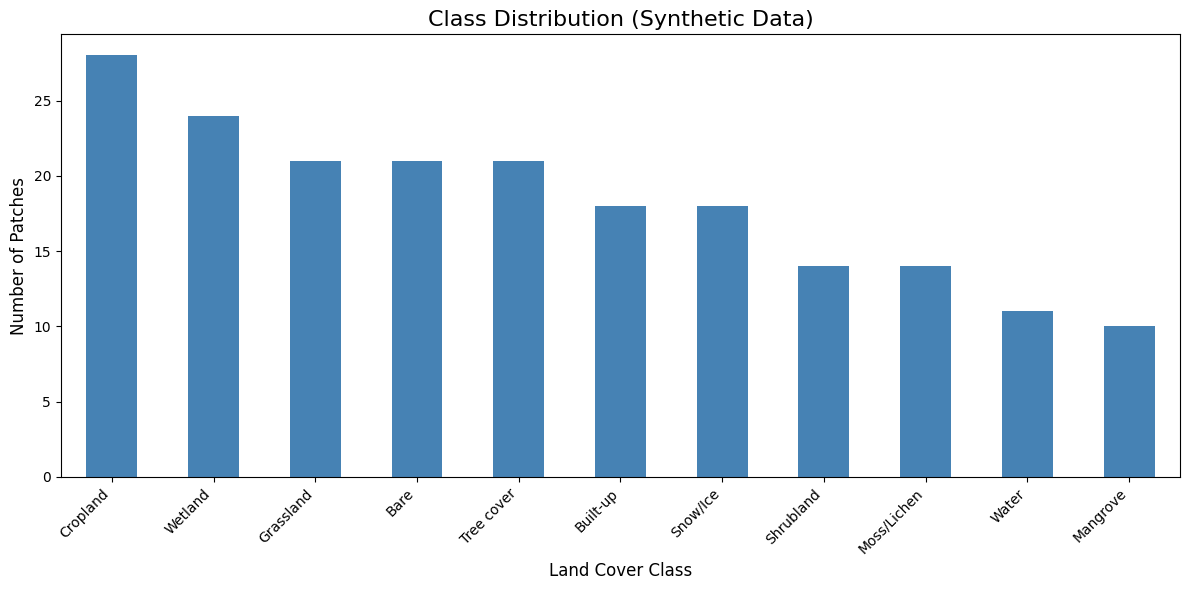


Class distribution:
  Cropland: 28 patches
  Wetland: 24 patches
  Grassland: 21 patches
  Bare: 21 patches
  Tree cover: 21 patches
  Built-up: 18 patches
  Snow/Ice: 18 patches
  Shrubland: 14 patches
  Moss/Lichen: 14 patches
  Water: 11 patches
  Mangrove: 10 patches


In [144]:
#Visualize Class Distribution
df = pd.DataFrame({'label': labels})
class_counts = df['label'].value_counts()
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar', color='steelblue')
plt.title('Class Distribution (Synthetic Data)', fontsize=16)
plt.xlabel('Land Cover Class', fontsize=12)
plt.ylabel('Number of Patches', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(f"\nClass distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} patches")

In [149]:
# Train-Test Split
import random
from sklearn.model_selection import train_test_split
import numpy as np
random.seed(42)
np.random.seed(42)
train_patches, test_patches, train_labels, test_labels = train_test_split(
    patches, labels,
    test_size=0.4,
    random_state=42,
    stratify=labels
)
print(f"  Total samples: {len(labels)}")
print(f"  Training samples: {len(train_labels)} ({len(train_labels)/len(labels)*100:.1f}%)")
print(f"  Testing samples: {len(test_labels)} ({len(test_labels)/len(labels)*100:.1f}%)")

  Total samples: 200
  Training samples: 100 (50.0%)
  Testing samples: 100 (50.0%)


In [150]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
class PatchDataset(Dataset):
    def __init__(self, patches, labels, label_to_idx, transform=None):
        self.patches = patches
        self.labels = labels
        self.label_to_idx = label_to_idx
        self.transform = transform
    def __len__(self):
        return len(self.patches)
    def __getitem__(self, idx):
        # Convert numpy array to PIL Image
        patch = Image.fromarray(self.patches[idx])
        label = self.labels[idx]
        label_idx = self.label_to_idx[label]
        if self.transform:
            patch = self.transform(patch)
        return patch, label_idx

In [151]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = PatchDataset(train_patches, train_labels, label_to_idx, transform=train_transform)
test_dataset = PatchDataset(test_patches, test_labels, label_to_idx, transform=test_transform)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {batch_size}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Test samples: {len(test_dataset)}")

  Training batches: 7
  Test batches: 7
  Batch size: 16
  Training samples: 100
  Test samples: 100


In [152]:
#ResNet18 Model for Land Cover Classification
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Device: {device}")
if device.type == 'cpu':
    print("  Running on CPU (training will be slower)")
model = resnet18(pretrained=True)
num_classes = 11
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
print(f"  Input features: {in_features}")
print(f"  Output classes: {num_classes}")
print(f"  Original ImageNet classes (1000) → Land cover classes ({num_classes})")
model = model.to(device)
print(f"\n Model moved to {device}")


 Device: cuda
  Input features: 512
  Output classes: 11
  Original ImageNet classes (1000) → Land cover classes (11)

 Model moved to cuda


In [153]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Non-trainable parameters: {total_params - trainable_params:,}")
print(f"  Output: {num_classes} land cover classes")


  Total parameters: 11,182,155
  Trainable parameters: 11,182,155
  Non-trainable parameters: 0
  Output: 11 land cover classes


In [154]:
# Training
num_epochs = 100
train_losses = []
print("Starting training...\n")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("\nTraining completed!")

Starting training...

Epoch [1/100] - Loss: 2.7368, Accuracy: 8.00%
Epoch [2/100] - Loss: 2.6160, Accuracy: 14.00%
Epoch [3/100] - Loss: 2.6088, Accuracy: 14.00%
Epoch [4/100] - Loss: 2.6157, Accuracy: 13.00%
Epoch [5/100] - Loss: 2.6804, Accuracy: 10.00%
Epoch [6/100] - Loss: 2.5419, Accuracy: 16.00%
Epoch [7/100] - Loss: 2.1322, Accuracy: 25.00%
Epoch [8/100] - Loss: 2.1604, Accuracy: 22.00%
Epoch [9/100] - Loss: 2.3039, Accuracy: 20.00%
Epoch [10/100] - Loss: 2.1154, Accuracy: 34.00%
Epoch [11/100] - Loss: 2.0888, Accuracy: 25.00%
Epoch [12/100] - Loss: 1.9771, Accuracy: 35.00%
Epoch [13/100] - Loss: 1.8726, Accuracy: 33.00%
Epoch [14/100] - Loss: 1.8178, Accuracy: 42.00%
Epoch [15/100] - Loss: 1.6556, Accuracy: 52.00%
Epoch [16/100] - Loss: 1.6624, Accuracy: 49.00%
Epoch [17/100] - Loss: 1.6557, Accuracy: 42.00%
Epoch [18/100] - Loss: 1.7524, Accuracy: 41.00%
Epoch [19/100] - Loss: 1.6567, Accuracy: 45.00%
Epoch [20/100] - Loss: 1.5192, Accuracy: 52.00%
Epoch [21/100] - Loss: 1.466

In [155]:
# Evaluate on Test Set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
test_accuracy = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"\nTotal test samples: {len(y_true)}")

Test Accuracy: 11.00%

Total test samples: 100
